In [20]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format='retina'

In [21]:
pd.set_option('display.max_rows',100)

In [22]:
predict_date='2018_12_23'

## Consumption_afterPV mode peakload already reduced from discharge but mode dutycycle not reduced

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


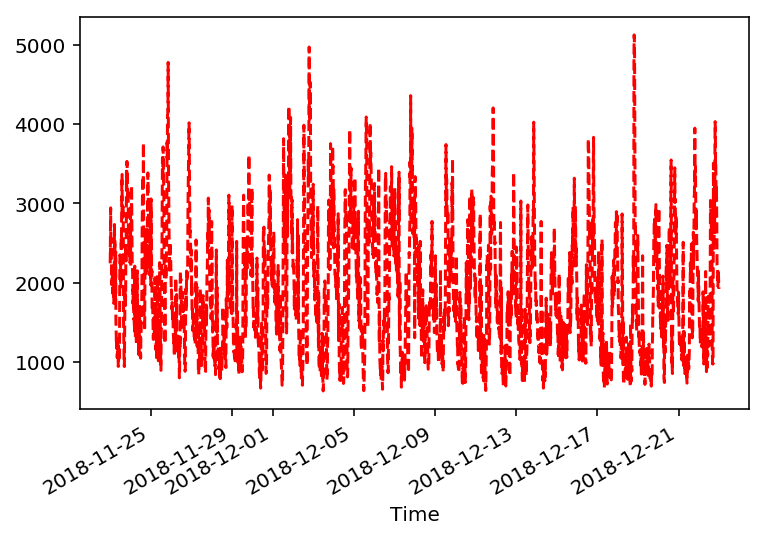

In [23]:
num_day=30

predict_day=int(predict_date[8:])
predict_month=int(predict_date[5:7])
predict_year=int(predict_date[0:4])

str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

daybefore=[]
pmb=predict_month-1
dayleft=num_day-predict_day

if predict_day>=num_day:
    day=predict_day-num_day
    while day<predict_day:
        daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(day).zfill(2))
        day+=1
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        for i in range(31-dayleft,32,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        for i in range(30-dayleft,31,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    else:
        if predict_year%4==0:
            for i in range(29-dayleft,30,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        else:
            for i in range(28-dayleft,29,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))

pathlist=[]
for i in daybefore:
    pathlist.append('Energy_Balance_'+str(i))

def clean(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.drop(['Generation'],axis=1,inplace=True)
    return rawdata

rawdata=[]

for i in pathlist:
    df=clean(i)
    rawdata.append(df)
    

data=rawdata[0]
for i in range(num_day-1):
    data=pd.concat([data,rawdata[i+1]])
    

for i in range(data.shape[0]):
    if data.iloc[i,0]==0:
        data.iloc[i,0]=data.iloc[i-96,0]

fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()

fit4.fittedvalues.plot(style='--', color='red')

forecast=fit4.forecast(96)

params=fit4.model.params


In [24]:
forecast

2880    1872.536931
2881    1899.528033
2882    1741.427878
2883    1707.801269
2884    1724.591362
2885    1594.332950
2886    1435.385801
2887    1496.983782
2888    1405.141933
2889    1384.723630
2890    1361.210887
2891    1280.089116
2892    1311.775517
2893    1282.837373
2894    1268.520762
2895    1207.936751
2896    1244.575524
2897    1210.225376
2898    1348.412166
2899    1939.045263
2900    1914.795021
2901    2273.562201
2902    1494.674339
2903    1189.830042
2904    1184.734397
2905    1721.011490
2906    1075.098388
2907    1040.509461
2908    1014.814362
2909    1033.889218
2910    1187.122517
2911    1220.412976
2912    1012.305473
2913    1046.437204
2914    1002.983060
2915     998.588443
2916    1193.297711
2917    1101.913571
2918    1053.660415
2919    1018.339195
2920    1218.639141
2921    1292.178865
2922    1312.318969
2923    1322.224062
2924    1231.581879
2925    1240.556745
2926    1101.154460
2927    1084.821527
2928    1219.312078
2929    1352.353210


In [25]:
Consumption=[]
for i in forecast:
    Consumption.append(i)
Consumption

[1872.5369312512714,
 1899.5280327893172,
 1741.4278776690046,
 1707.8012693234637,
 1724.5913623941162,
 1594.3329503022464,
 1435.3858007694469,
 1496.9837824672315,
 1405.1419334059542,
 1384.7236300592203,
 1361.210887378626,
 1280.0891162627486,
 1311.7755172647635,
 1282.8373733452352,
 1268.5207623781453,
 1207.936750943732,
 1244.5755242862506,
 1210.225375603253,
 1348.4121660236835,
 1939.04526294348,
 1914.7950206764099,
 2273.562201027994,
 1494.674338551487,
 1189.8300424866031,
 1184.7343969165743,
 1721.0114898169566,
 1075.0983883029483,
 1040.5094613022768,
 1014.8143624368302,
 1033.8892178062747,
 1187.1225165071655,
 1220.412975698107,
 1012.3054726789195,
 1046.4372044799638,
 1002.9830599509652,
 998.5884430958837,
 1193.2977114438495,
 1101.9135712899683,
 1053.6604150392739,
 1018.3391945328354,
 1218.6391413497138,
 1292.1788647715134,
 1312.3189687440763,
 1322.2240617043003,
 1231.5818793681374,
 1240.556745314775,
 1101.154459997448,
 1084.8215270370563,
 12

In [26]:
predictday=predict_date[0:4]+predict_date[5:7]+predict_date[8:10]
minu=[]
h=[]
m=[]
index=[]
Time=[]
for i in range(1,96):
    minu.append(str((i%4)*15).zfill(2))
    h.append(str(i//4).zfill(2))
for i in range(1,96):
    index.append(predictday+h[i-1]+minu[i-1])
for i in index:
    Time.append(pd.to_datetime(i))
Time.append(pd.to_datetime(predictday+'0000'))
len(Time)
    

    
#pd.to_datetime('201812230010')

96

## Create Dataframe

In [27]:
DF = pd.DataFrame()
DF['Consumption']=Consumption
DF['Time']=Time
DF.set_index('Time',inplace=True)
DF

,Consumption
Time,
2018-12-23 00:15:00,1872.536931
2018-12-23 00:30:00,1899.528033
2018-12-23 00:45:00,1741.427878
2018-12-23 01:00:00,1707.801269
2018-12-23 01:15:00,1724.591362
2018-12-23 01:30:00,1594.332950
2018-12-23 01:45:00,1435.385801
2018-12-23 02:00:00,1496.983782
2018-12-23 02:15:00,1405.141933


In [28]:
def dutycyclemode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()/4

    datanotstart=rawdata[rawdata.Generation==0]
    dataonlystart=rawdata[rawdata.Generation!=0]
    start_time=dataonlystart.index[0]
    consumption_night=rawdata.loc[:start_time,'Consumption'].sum()/4

    if totalcharge+batt>9600:
        discharge_only_at_night=1
    else:
        discharge_only_at_night=0

    if batt-consumption_night>0.6*9600:
        batt_start=batt-consumption
    else:
        batt_start=0.6*9600


    contactor=[]

    for i in rawdata[rawdata.index[0]:start_time].drop(start_time).index:
        if discharge_only_at_night==1:
            contactor.append(1)
        else:
            contactor.append(0)

    for i in rawdata[start_time:].index:
        if rawdata.loc[i,'Charge'] > 0:
            contactor.append(1)
        elif batt_start+totalcharge <= 9600:
            contactor.append(0)
        else:
            contactor.append(1)

    rawdata['Contactor']=contactor

    remain=totalcharge*4

    rawdata['Discharge']=rawdata['Contactor']*0
    for i in rawdata.index:
        if rawdata.loc[i,'Contactor']==1 and rawdata.loc[i,'Charge']==0:
            if remain >= rawdata.loc[i,'Consumption_afterPV']:
                rawdata.loc[i,'Discharge']= rawdata.loc[i,'Consumption_afterPV']
                remain=remain- rawdata.loc[i,'Consumption_afterPV']
            else:
                rawdata.loc[i,'Discharge']=remain
                remain=0
    return rawdata


In [29]:
def peakloadmode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()

    data=rawdata

    peakloadtotal=0

    for i in range(1,96):
        peakloaddf=data.nlargest(i,columns='Consumption_afterPV').Consumption_afterPV
        #print(peakloaddf)
        peakload=peakloaddf.iloc[i-1:i]
        peakloadtotal += peakload.iloc[0]
        print(peakload)
        #print(peakloadtotal)
        if peakloadtotal>=totalcharge:
            remain=(peakloadtotal-totalcharge)
            print(remain)
            for j in peakloaddf.index:
                data.loc[j:j,'Consumption_afterPV']=0
            data.loc[peakload.index,'Consumption_afterPV']=remain
            break

    data['Discharge']=data.Consumption_afterPV*0
    for i in peakloaddf.index:
        data.loc[i:i,'Discharge']=data.loc[i:i,'Consumption']-data.loc[i:i,'Generation']-data.loc[i:i,'Consumption_afterPV']

    Contactor=[]
    for i in data.index:
        if data.loc[i,'Charge']>0:
            Contactor.append(1)
        elif data.loc[i,'Discharge']>0:
            Contactor.append(1)
        else:
            Contactor.append(0)
    data['Contactor']=Contactor
    return data

In [30]:
import os
import pandas as pd
import json
import datetime

def createDayDataframe(filename):
    path = "tongsdata/"
    filedate = filename.split(".")[0].split("-")

    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())

    #  Create X DataFrame
    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T

    #  Create y DataFrame
    energyBalanceFilename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(filedate[0], filedate[1], filedate[2]) #change due to json filename
    energyBalance = pd.read_csv(path + energyBalanceFilename, delimiter=";")

    energyBalance_DF = pd.DataFrame(index=energyBalance.iloc[:-1,0].apply(lambda x: x[2:-1]))
    energyBalance_DF['PV Power Generation'] = energyBalance['PV power generation / Mean values [W]  '].values[:-1]
    energyBalance_DF = energyBalance_DF[energyBalance_DF != ' ']
    energyBalance_DF = energyBalance_DF.dropna()
    
    #  Join X y DataFrame
    data = todayData_DF.join(energyBalance_DF)
    return data

def cleanDataframe(masterDF):
    masterData_cleaned = masterDF.reset_index()
    masterData_cleaned = masterData_cleaned.rename(columns={'index': 'time_of_day'})
    masterData_cleaned = masterData_cleaned[masterData_cleaned['PV Power Generation'].notna()]
    masterData_cleaned['month'] = masterData_cleaned['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    masterData_cleaned['cloudCover'] = masterData_cleaned['cloudCover'].fillna(value=masterData_cleaned['cloudCover'].mean())
    masterData_cleaned['PV Power Generation'] = masterData_cleaned['PV Power Generation'].apply(lambda x: x.replace(",", "")).astype('float')
    return masterData_cleaned

def featureEngineering(masterDF):
    masterDF = masterDF.drop(columns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure'])
    masterDF = pd.get_dummies(masterDF, columns=['time_of_day', 'precipType', 'uvIndex', 'month']) 
    return masterDF

files = os.listdir("tongsdata/")

#files.remove(".DS_Store")
files.remove("energyBalance")

masterData = pd.DataFrame()

for file in files:
    r = createDayDataframe(file).loc['06:30':'18:00']
    print(file, r.shape)
    masterData = pd.concat([masterData, r], axis=0)
    
masterData = cleanDataframe(masterData)
masterData = featureEngineering(masterData)

features = list(masterData.drop(columns=['PV Power Generation']).columns)

masterData = masterData.dropna()

X = masterData.drop(columns=['PV Power Generation']).astype('float').values
y = masterData['PV Power Generation'].astype('float').values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

training_features, testing_features, training_target, testing_target = train_test_split(X, y)

# Average CV score on the training set was:-91867.4890210794
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=1, min_samples_split=7, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
print(mean_squared_error(testing_target, results), 
mean_absolute_error(testing_target, results), 
r2_score(testing_target, results))


def pvpredict(predict_date) :
    path = "tongsdata/"
    filename = predict_date.replace("_",'-') + '.json'

    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())

    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T
    todayData_DF.index.names=['time_of_day']
    todayData_DF = todayData_DF.loc['06:30':'18:00']
    todayData_DF = todayData_DF.reset_index()
    todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
    dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure']
    for i in dropcolumns:
        if i in todayData_DF.columns:
            todayData_DF = todayData_DF.drop(columns=[i])
    todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
    
    masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
    for i in range(len(masterData_for_predict.columns)) : #drop power balance
        if masterData_for_predict.columns[i] not in todayData_DF.columns:
            todayData_DF.insert(i, masterData.columns[i+1], 0)
    missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index
    import math
    for i in missingvalue:
        for j in todayData_DF.columns:
            if math.isnan(todayData_DF.loc[i,j]) :
                todayData_DF.loc[i,j] = (todayData_DF.loc[i-1,j]+todayData_DF.loc[i+1,j])/2
    first_predict = todayData_DF.astype('float').values
    
    results_first_predict = exported_pipeline.predict(first_predict)
    results_first_predict = np.array(results_first_predict).tolist()
    for i in range(25):
        results_first_predict.insert(0,0.0)
    for j in range (24):
        results_first_predict.append(0.0)
    return results_first_predict

2018-10-01.json (47, 15)
2018-10-02.json (47, 14)
2018-10-03.json (47, 14)
2018-10-04.json (47, 15)
2018-10-05.json (47, 15)
2018-10-06.json (47, 15)
2018-10-07.json (47, 15)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-10-08.json (47, 15)
2018-10-09.json (47, 15)
2018-10-10.json (47, 15)
2018-10-11.json (47, 15)
2018-10-12.json (47, 15)
2018-10-13.json (47, 14)
2018-10-14.json (47, 15)
2018-10-15.json (47, 15)
2018-10-16.json (47, 15)
2018-10-17.json (47, 14)
2018-10-18.json (47, 14)
2018-10-19.json (47, 15)
2018-10-20.json (47, 15)
2018-10-21.json (47, 15)
2018-10-22.json (47, 15)
2018-10-23.json (47, 15)
2018-10-24.json (47, 14)
2018-10-25.json (47, 15)
2018-10-26.json (47, 15)
2018-10-27.json (47, 15)
2018-10-28.json (47, 15)
2018-10-29.json (47, 15)
2018-10-30.json (47, 15)
2018-10-31.json (47, 15)
2018-11-01.json (47, 15)
2018-11-02.json (47, 13)
2018-11-03.json (47, 15)
2018-11-04.json (47, 14)
2018-11-05.json (47, 14)
2018-11-06.json (47, 15)
2018-11-07.json (47, 14)
2018-11-08.json (47, 15)
2018-11-09.json (47, 14)
2018-11-10.json (47, 15)
2018-11-11.json (47, 14)
2018-11-12.json (47, 15)
2018-11-13.json (47, 14)
2018-11-14.json (47, 15)
2018-11-15.json (47, 15)
2018-11-16.json (47, 15)


In [31]:
Generation=pvpredict(predict_date)

In [32]:
DF['Generation']=Generation
DF

,Consumption,Generation
Time,,
2018-12-23 00:15:00,1872.536931,0.000000
2018-12-23 00:30:00,1899.528033,0.000000
2018-12-23 00:45:00,1741.427878,0.000000
2018-12-23 01:00:00,1707.801269,0.000000
2018-12-23 01:15:00,1724.591362,0.000000
2018-12-23 01:30:00,1594.332950,0.000000
2018-12-23 01:45:00,1435.385801,0.000000
2018-12-23 02:00:00,1496.983782,0.000000
2018-12-23 02:15:00,1405.141933,0.000000


In [34]:
dutycyclemode(DF,100)

,Consumption,Generation,Charge,Consumption_afterPV,Contactor,Discharge
Time,,,,,,
2018-12-23 00:15:00,1872.536931,0.000000,0.000000,1872.536931,1,1872.536931
2018-12-23 00:30:00,1899.528033,0.000000,0.000000,1899.528033,1,1899.528033
2018-12-23 00:45:00,1741.427878,0.000000,0.000000,1741.427878,1,1741.427878
2018-12-23 01:00:00,1707.801269,0.000000,0.000000,1707.801269,1,108.035109
2018-12-23 01:15:00,1724.591362,0.000000,0.000000,1724.591362,1,0.000000
2018-12-23 01:30:00,1594.332950,0.000000,0.000000,1594.332950,1,0.000000
2018-12-23 01:45:00,1435.385801,0.000000,0.000000,1435.385801,1,0.000000
2018-12-23 02:00:00,1496.983782,0.000000,0.000000,1496.983782,1,0.000000
2018-12-23 02:15:00,1405.141933,0.000000,0.000000,1405.141933,1,0.000000


In [36]:
clean('Energy_Balance_2018_12_23')

,Consumption
Time,
2018-12-23 00:15:00,1840
2018-12-23 00:30:00,1658
2018-12-23 00:45:00,1806
2018-12-23 01:00:00,1672
2018-12-23 01:15:00,1509
2018-12-23 01:30:00,1429
2018-12-23 01:45:00,1806
2018-12-23 02:00:00,1675
2018-12-23 02:15:00,1429


In [39]:
def clean1(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

In [41]:
check=clean1('Energy_Balance_2018_12_23')

In [42]:
check['ForecastGen']=DF['Generation']
check['ForecastCon']=DF['Consumption']

In [48]:
check

,Generation,Consumption,ForecastGen,ForecastCon
Time,,,,
2018-12-23 00:15:00,0,1840,0.000000,1872.536931
2018-12-23 00:30:00,0,1658,0.000000,1899.528033
2018-12-23 00:45:00,0,1806,0.000000,1741.427878
2018-12-23 01:00:00,0,1672,0.000000,1707.801269
2018-12-23 01:15:00,0,1509,0.000000,1724.591362
2018-12-23 01:30:00,0,1429,0.000000,1594.332950
2018-12-23 01:45:00,0,1806,0.000000,1435.385801
2018-12-23 02:00:00,0,1675,0.000000,1496.983782
2018-12-23 02:15:00,0,1429,0.000000,1405.141933


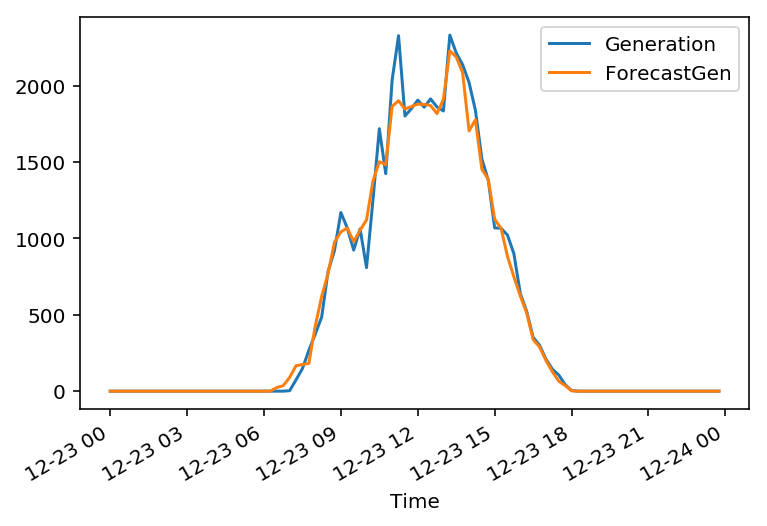

In [55]:

check[['Generation' ,'ForecastGen']].plot(kind='line')

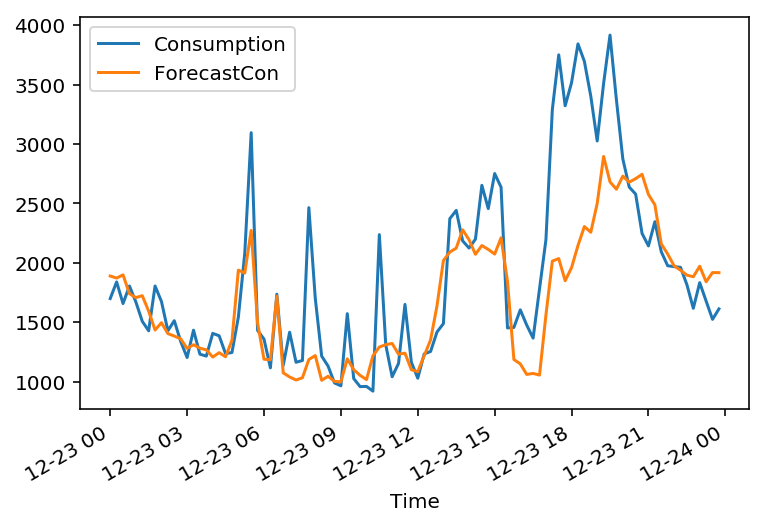

In [56]:
check[['Consumption' ,'ForecastCon']].plot(kind='line')

In [61]:
check['Error']=(abs(check['Generation']-check['ForecastGen'])/check['Generation'])*100

In [65]:
check.loc['2018-12-23 07:30:00':'2018-12-23 18:00:00','Error'].mean()

9.499149585626824

In [60]:
check['Error'].mean()

inf

In [64]:
check

,Generation,Consumption,ForecastGen,ForecastCon,Error
Time,,,,,
2018-12-23 00:15:00,0,1840,0.000000,1872.536931,NaN
2018-12-23 00:30:00,0,1658,0.000000,1899.528033,NaN
2018-12-23 00:45:00,0,1806,0.000000,1741.427878,NaN
2018-12-23 01:00:00,0,1672,0.000000,1707.801269,NaN
2018-12-23 01:15:00,0,1509,0.000000,1724.591362,NaN
2018-12-23 01:30:00,0,1429,0.000000,1594.332950,NaN
2018-12-23 01:45:00,0,1806,0.000000,1435.385801,NaN
2018-12-23 02:00:00,0,1675,0.000000,1496.983782,NaN
2018-12-23 02:15:00,0,1429,0.000000,1405.141933,NaN
